In [3]:
import json
import pandas as pd
import scipy.io as sio
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox,yeojohnson
from sklearn.preprocessing import *
from sklearn.svm import SVR
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from gc import callbacks
import joblib
import MyLibrary as ml
#from functools import partial

In [34]:
gridNumber=ml.dataSVN["number_of_search"]
class NoneScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

def save_progress(estimator, X, y):
    results = estimator.cv_results_
    iteration = results['iter']
    filename = rf".\VegaTesi\GridSearchSalve\SVN\gridN{gridNumber}\grid_search_progress_iteration_{iteration}.pkl"
    joblib.dump(results, filename)

# Funzione di callback per stampare iperparametri e score
def print_results(estimator, X, y):
    results = estimator.cv_results_
    print("Iterazione: {}".format(results['iter']))
    print("Iperparametri:")
    for param, value in results['params'].items():
        print("  {}: {}".format(param, value))
    print("Score medio R^2:", results['mean_test_R^2'])
    print("Score medio MSE:", results['mean_test_MSE'])
    print()
    

In [4]:
ds=ml.dataFrame.RenameColumns(ml.pathDataSet)
ds.head(len(ds))

,Velocità,Angolo,X Sensore,Frequenza,Pressione
0,0.83,0.0,884,8.705373,136.214930
1,0.83,0.0,884,10.959415,137.277046
2,0.83,0.0,884,13.797086,136.765639
3,0.83,0.0,884,17.369503,136.208511
4,0.83,0.0,884,21.866908,133.538084
...,...,...,...,...,...
36703,0.98,6.0,3,17369.502567,145.463205
36704,0.98,6.0,3,21866.908172,143.944513
36705,0.98,6.0,3,27528.806375,142.171114
36706,0.98,6.0,3,34656.713902,139.664204


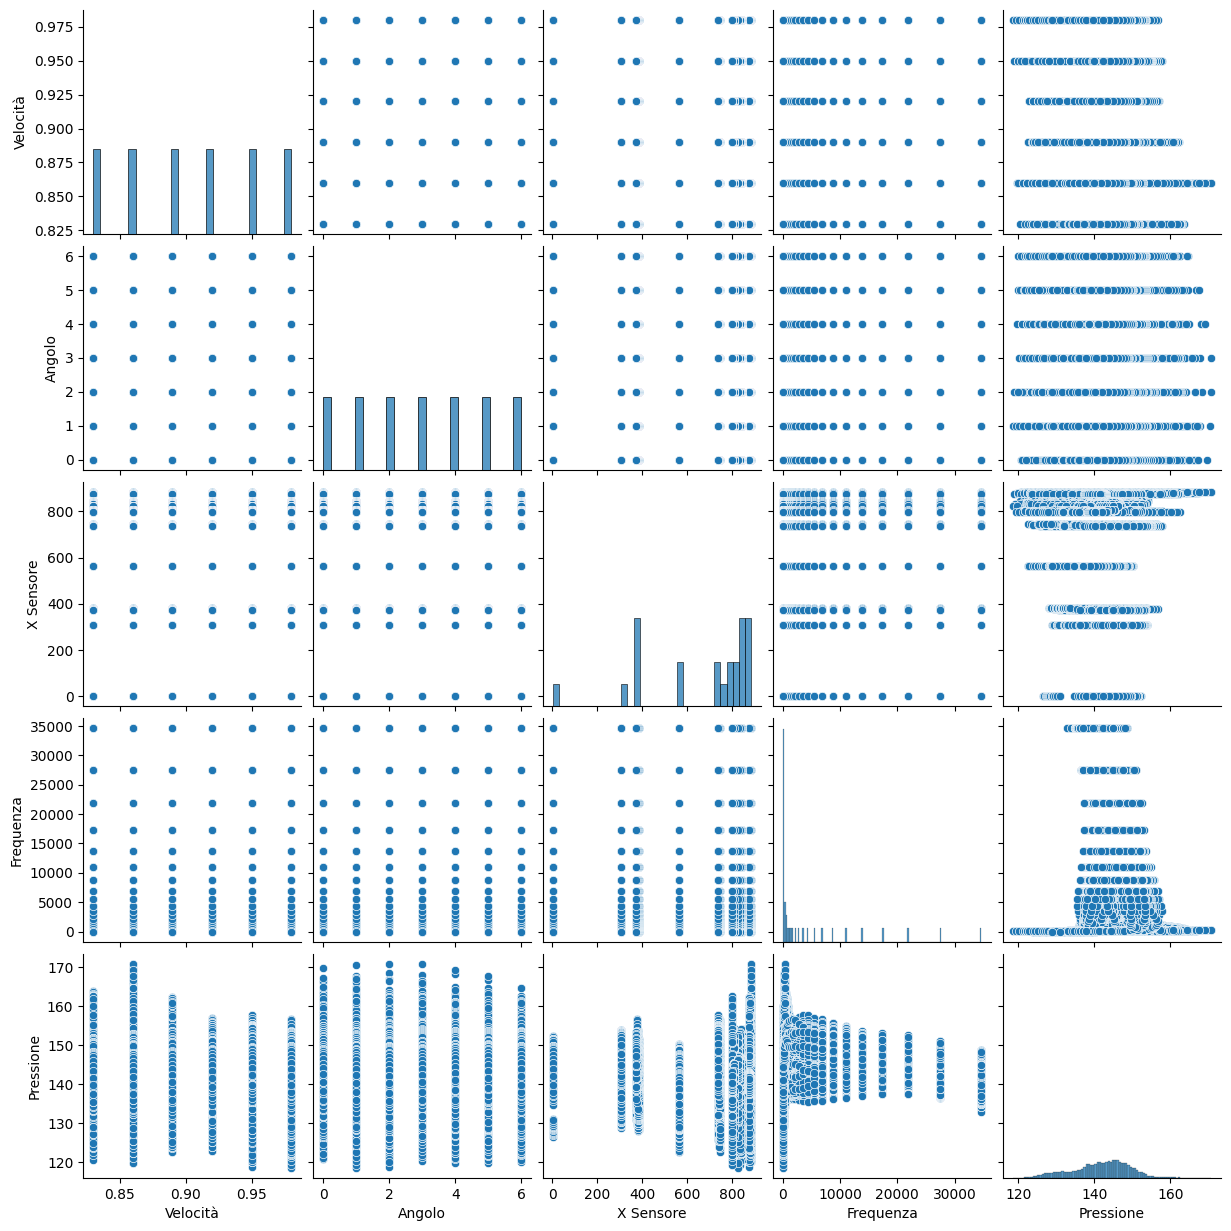

In [5]:
# Visualizza la matrice di dispersione delle features
sns.pairplot(ds)
plt.show()

In [6]:
ds.describe()

,Velocità,Angolo,X Sensore,Frequenza,Pressione
count,36708.000000,36708.000000,36708.000000,36708.000000,36708.000000
mean,0.905000,3.000000,664.130435,4433.456454,141.764016
std,0.051235,2.000027,239.417093,8123.653131,7.373487
min,0.830000,0.000000,3.000000,0.000000,118.589412
25%,0.860000,1.000000,383.000000,54.927190,137.346431
50%,0.905000,3.000000,797.000000,492.787039,142.620317
75%,0.950000,5.000000,841.000000,4363.021782,147.045070
max,0.980000,6.000000,884.000000,34656.713902,170.762698


In [7]:
# Predizioni del modello
filtro=(ds['X Sensore'].isin([884])) & (ds['Velocità']==0.83) & (ds['Angolo']==0.0)
ds_filtered = ds[filtro]
Input = ds.iloc[:, 0:4].values
output = ds.iloc[:,4].values
print("input",Input)
print("output",output)

input [[8.30000000e-01 0.00000000e+00 8.84000000e+02 8.70537294e+00]
 [8.30000000e-01 0.00000000e+00 8.84000000e+02 1.09594152e+01]
 [8.30000000e-01 0.00000000e+00 8.84000000e+02 1.37970863e+01]
 ...
 [9.80000000e-01 6.00000000e+00 3.00000000e+00 2.75288064e+04]
 [9.80000000e-01 6.00000000e+00 3.00000000e+00 3.46567139e+04]
 [9.80000000e-01 6.00000000e+00 3.00000000e+00 0.00000000e+00]]
output [136.21493038 137.27704596 136.76563876 ... 142.17111449 139.66420412
 130.85555006]


In [26]:
X_train, X_test, y_train, y_test = train_test_split(Input, output, test_size=0.2, random_state=42)

scalers = {
    'NoneScaler': NoneScaler(),
    'Normalizer': Normalizer(),
    'QuantileTransformer': QuantileTransformer(),
    'PowerTransformer': PowerTransformer(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler()
}
scaler = scalers['PowerTransformer']

In [27]:
# Normalizzazione dei dati
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = y_train.ravel()
y_test = y_test.ravel()
# Convert continuous target variable to discrete classes

In [31]:
# Addestramento del modello
svr_model  = SVR(kernel='rbf',C=62.0,gamma='auto',verbose=True,epsilon=1.5)
svr_model.fit(X_train_scaled, y_train)
score = svr_model.score(X_test_scaled, y_test)
print("R^2", score)
y_predic=svr_model.predict(X_test_scaled)
mse=mean_squared_error(y_test,y_predic)
print("MSE",mse)

[LibSVM]R^2 0.8105241584721822
MSE 10.436923156203788


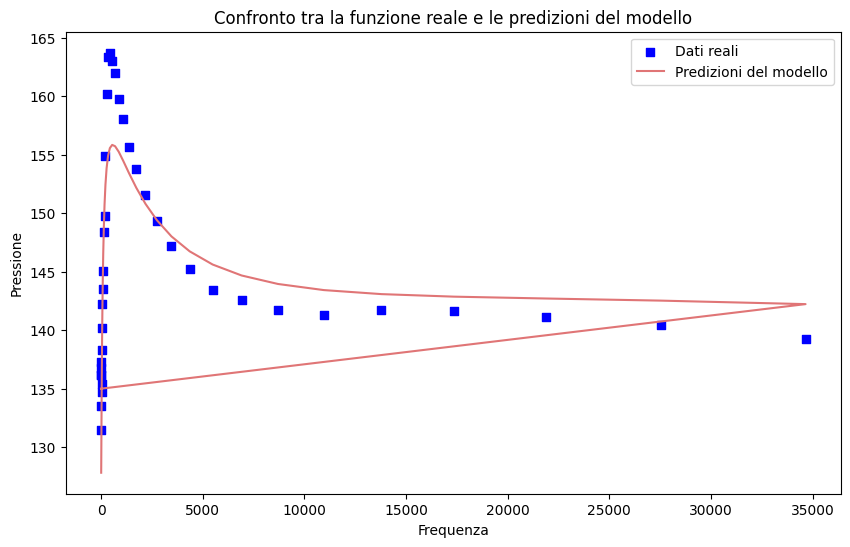

In [32]:
Input2 = ds_filtered.iloc[:, 0:4].values
Output = ds_filtered.iloc[:, 4:5].values
Input2=scaler.transform(Input2)
predictions_tree = svr_model.predict(Input2)
# Plottaggio dei risultati
plt.figure(figsize=(10, 6))
plt.scatter(ds_filtered['Frequenza'], Output, color='blue', label='Dati reali',marker='s')
color = (224/255, 117/255, 118/255)
plt.plot(ds_filtered['Frequenza'], predictions_tree, color=color, label='Predizioni del modello')
#plt.plot(X_real, y_real, color='green', label='Funzione reale')

plt.xlabel('Frequenza')
plt.ylabel('Pressione')
plt.title('Confronto tra la funzione reale e le predizioni del modello')
#plt.title('Accuracy: {:.2f}'.format(score))
plt.legend()
plt.show()

#Auto turinig Iper-parametri

In [14]:
# Definizione della pipeline con lo scaler e il modello SVR
pipeline = Pipeline([
    ('scaler', scalers['QuantileTransformer']),  # Sostituisci con lo scaler desiderato
    ('svr', SVR(verbose=True))
])

# Definizione degli iperparametri da esplorare
param_grid = {
    'scaler': list(scalers.values()),
    'svr__C': [0.1, 1.0, 10.0],
    'svr__gamma': ['auto', 'scale'],
    'svr__epsilon': [0.1, 0.2, 0.5]
}

# Definizione della metrica da ottimizzare
scoring = {'R^2': 'r2', 'MSE': make_scorer(mean_squared_error)}

# Ricerca degli iperparametri migliori tramite GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='R^2', cv=5,n_jobs=-1,verbose=3)
grid_search.fit(X_train, y_train)

# Valutazione delle prestazioni del modello ottimizzato
print("Best parameters found:")
print(grid_search.best_params_)
print("Best R^2 score on validation set:", grid_search.best_score_)
print("MSE on validation set:", grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_])

# Valutazione delle prestazioni del modello ottimizzato sul set di test
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("R^2 score on test set:", test_score)
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("MSE on test set:", test_mse)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LibSVM]Best parameters found:
{'scaler': QuantileTransformer(), 'svr__C': 10.0, 'svr__epsilon': 0.5, 'svr__gamma': 'scale'}
Best R^2 score on validation set: 0.7703975898126755
MSE on validation set: 12.433229438167036
R^2 score on test set: 0.7816205042319601
MSE on test set: 12.029027013910591


In [42]:
# Definizione della pipeline con lo scaler e il modello SVR
data=ml.dataSVN
gridNumber=data["number_of_search"]
data["SVN"]["number_of_search"]=gridNumber+1
ml.json_utils.write_json_file(ml.pathSVN, data)

pipeline = Pipeline([
    ('scaler', scalers['PowerTransformer']),  # Sostituisci con lo scaler desiderato
    ('svr', SVR(verbose=True))
])
c_cerca=np.arange(57.5, 62.5, 0.5)
c_cerca=np.delete(c_cerca, np.where(c_cerca == 60.0))
#c_cerca=np.concatenate(([62.0]))
e_cerca=np.concatenate(([1.5],np.arange(1, 1.5, 0.1),np.arange(1.6, 2, 0.1)))
print(len(c_cerca),len(e_cerca))
print(e_cerca)
# Definizione degli iperparametri da esplorare
param_grid = {
    'scaler': [scalers['PowerTransformer']],
    'svr__C': [62.0],
    'svr__gamma': ['auto'],
    'svr__epsilon': [1.5],
    'svr__kernel': ['rbf','linear','poly','sigmoid']
}

# Definizione della metrica da ottimizzare
scoring = {'R^2': 'r2', 'MSE': make_scorer(mean_squared_error)}

grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='R^2', cv=5,n_jobs=-1,verbose=3,return_train_score=True)
grid_search.fit(X_train, y_train)

# Valutazione delle prestazioni del modello ottimizzato
print("Best parameters found:")
print(grid_search.best_params_)
print("Best R^2 score on validation set:", grid_search.best_score_)
print("MSE on validation set:", grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_])

# Valutazione delle prestazioni del modello ottimizzato sul set di test
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("R^2 score on test set:", test_score)
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("MSE on test set:", test_mse)

9 10
[1.5 1.  1.1 1.2 1.3 1.4 1.6 1.7 1.8 1.9]
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LibSVM]Best parameters found:
{'scaler': PowerTransformer(), 'svr__C': 62.0, 'svr__epsilon': 1.5, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Best R^2 score on validation set: 0.7987105264413928
MSE on validation set: 10.899084045675787
R^2 score on test set: 0.8105241584721822
MSE on test set: 10.436923156203788


In [43]:
print(grid_search.best_params_)
print(grid_search.cv_results_['mean_test_R^2'])
nuovoBlocco={
    "grid_search": data["SVN"]["number_of_search"],
    "scaler":grid_search.best_params_['scaler'].__class__.__name__,
    "C":grid_search.best_params_['svr__C'],
    "epsilon":grid_search.best_params_['svr__epsilon'],
    "gamma":grid_search.best_params_['svr__gamma'],
    "R^2":grid_search.best_score_,
    "MSE":grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_]
}
data["Iper-Parametri_Ottimizati"].append(nuovoBlocco)
ml.json_utils.write_json_file(ml.pathSVN, data)

{'scaler': PowerTransformer(), 'svr__C': 62.0, 'svr__epsilon': 1.5, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
[ 7.98710526e-01  3.48222826e-01  2.96324325e-01 -4.38984463e+06]
